<a href="https://colab.research.google.com/github/samuelsushanth/BeHealthy_NLP_Medical_Entity_Recognition/blob/main/BeHealthy_NLP_Medical_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [ ]:
!pip install pycrf
!pip install sklearn-crfsuite

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1871 sha256=ec398989d1f4d26abb3ecf2e5578f3454a52168a3af0b506a5555b274a72c293
  Stored in directory: /root/.cache/pip/wheels/fd/3a/fb/e4d15c9c2b169f43811b23a863ee9717ff3eda5d2301789043
Successfully built pycrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00


In [ ]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


In [ ]:
def load_n_preprocess(file_name):
    opened = open(file_name, 'r')
    loaded = opened.readlines()
    opened.close()

    all_sentence = []
    sentence = ""

    for word in loaded:
        word = word.strip() # removing any space
        if word == "":
            all_sentence.append(sentence) # To append the final sentence list
#             print(sentence)
#             print("***********")
            sentence = ""
        else:
            if sentence:
                sentence = sentence + " " + word
            else:
                sentence = word

    return all_sentence

### Construct the proper sentences from individual words and print the 5 sentences.

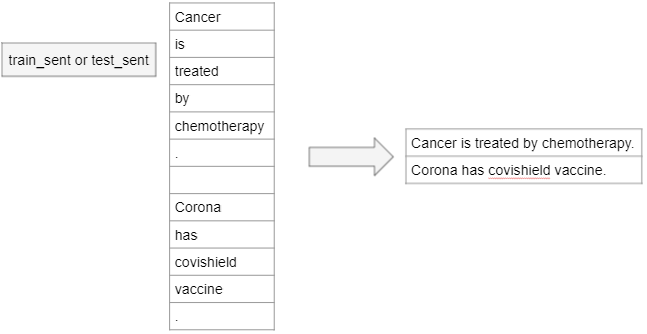

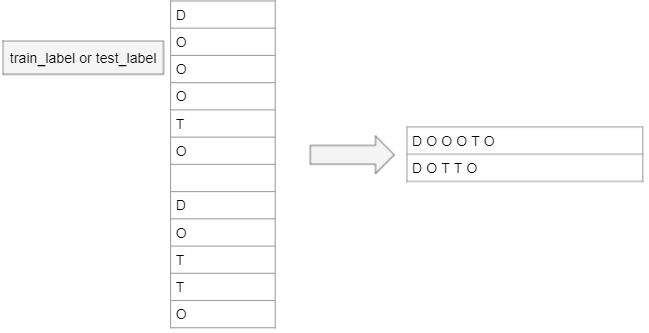

In [ ]:
train_sent = load_n_preprocess('train_sent')
train_label = load_n_preprocess('train_label')
test_sent = load_n_preprocess('test_sent')
test_label = load_n_preprocess('test_label')

In [ ]:
def print_sent(sents, label, count=5):
    for i in range(count):
        print("Sentence", i, " : ", sents[i])

        display(pd.DataFrame([sents[i].split(), label[i].split()], columns = np.arange(len(sents[i].split())), index = ["sentences", "label"]))

#         print("Label", i, " : ", label[i])
#         print( "###################"*5, "\n")

#     https://stackoverflow.com/questions/51288869/print-visually-pleasing-dataframes-in-for-loop-in-jupyter-notebook-pandas

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
opened = open("train_label", 'r')
loaded = opened.readlines()
opened.close()


In [ ]:
# Reading the train and test sentences and labels
with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels_by_word = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels_by_word = test_labels_file.readlines()

In [ ]:
# Sanity check to see that the number of tokens and no. of corresponding labels match.
print("Count of tokens in training set\n","No. of words: ",len(train_words),"\nNo. of labels: ",len(train_labels_by_word))
print("\n\nCount of tokens in test set\n","No. of words: ",len(test_words),"\nNo. of labels: ",len(test_labels_by_word))


Count of tokens in training set
 No. of words:  48501 
No. of labels:  48501


Count of tokens in test set
 No. of words:  19674 
No. of labels:  19674


<ipython-input-15-b62fc56042b9>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


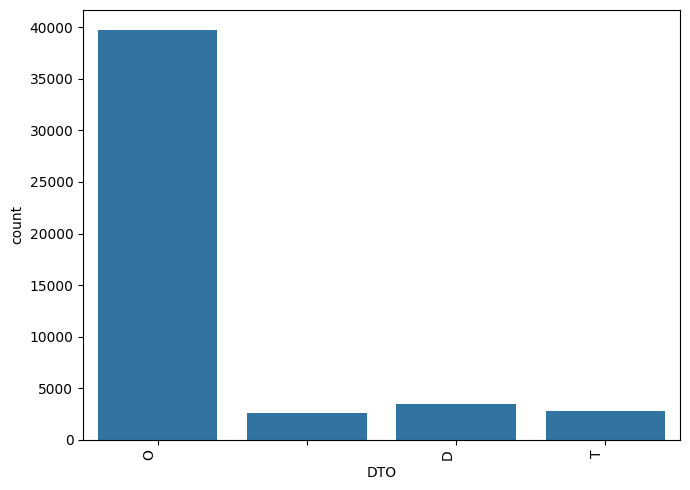

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='DTO', data=pd.DataFrame(loaded, columns=["DTO"]), orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [ ]:
opened = open("test_label", 'r')
loaded = opened.readlines()
opened.close()

<ipython-input-18-170477f1d9d9>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


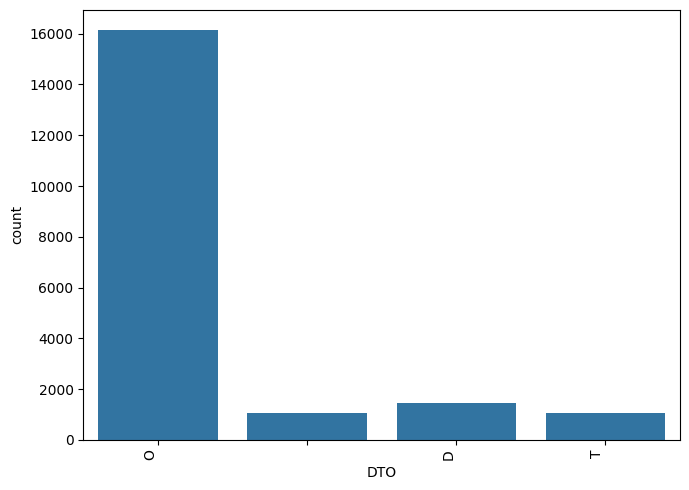

In [ ]:
#Words distribution across DTO in test label
plt.figure(figsize=(7, 5))
ax = sns.countplot(x ='DTO', data=pd.DataFrame(loaded, columns=["DTO"]), orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

### Printing first 5 TRAIN sentence and it's labels

In [ ]:
print_sent(train_sent, train_label, count=5)

Sentence 0  :  All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
sentences,All,live,births,>,or,=,23,weeks,at,the,...,",",and,practice,group,(,to,reflect,risk,status,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 1  :  The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
sentences,The,total,cesarean,rate,was,14.4,%,(,344,of,...,primary,rate,was,11.4,%,(,244,of,2144,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 2  :  Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sentences,Abnormal,presentation,was,the,most,common,indication,(,25.6,%,",",88,of,344,)
label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 3  :  The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
sentences,The,``,corrected,'',cesarean,rate,(,maternal-fetal,medicine,and,...,primary,rate,was,9.6,%,(,190,of,1975,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 4  :  Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
sentences,Arrest,of,dilation,was,the,most,common,indication,in,both,...,'',subgroups,(,23.4,and,24.6,%,",",respectively,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


### Printing first 5 TEST sentence and it's labels

In [ ]:
print_sent(test_sent, test_label, count=5)

Sentence 0  :  Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
sentences,Furthermore,",",when,all,deliveries,were,analyzed,",",regardless,of,...,2214,;,primary,9.2,%,",",183,of,1994,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 1  :  As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
sentences,As,the,ambient,temperature,increases,",",there,is,an,increase,in,insensible,fluid,loss,and,the,potential,for,dehydration
label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 2  :  The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
sentences,The,daily,high,temperature,ranged,from,71,to,104,degrees,...,ranged,from,1.7,to,24.7,cm,during,the,study,period
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 3  :  There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
sentences,There,was,a,significant,correlation,between,the,2-,",",3-,...,=,0.31,",",p,&,#,60,;,0.001,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 4  :  Fluctuations in ambient temperature are inversely correlated to changes in AFI


,0,1,2,3,4,5,6,7,8,9,10
sentences,Fluctuations,in,ambient,temperature,are,inversely,correlated,to,changes,in,AFI
label,O,O,O,O,O,O,O,O,O,O,O


### Count the number of sentences in the processed train and test dataset

In [ ]:
print("No. sentences in processed train dataset is: ", len(train_sent))
print("No. sentences in processed test dataset is: ", len(test_sent))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [ ]:
print("No. sentences in processed train dataset is: ", len(train_label))
print("No. sentences in processed test dataset is: ", len(test_label))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

Extracting NOUN or PROPN using tokens

In [ ]:
all_noun_propn = []
all_sentence = train_sent + test_sent

for sentence in all_sentence:
    doc = model(sentence)

    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            all_noun_propn.append(token.text)

In [ ]:
len(all_noun_propn)

24373

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [ ]:
#noun_pos = pd.DataFrame({"NOUN_PROPN":noun_propn,"POS_tag":pos_tag})
#print("Top 25 comon tokens with PoS tag of 'NOUN' or 'PROPN' \n")
#print(noun_pos["NOUN_PROPN"].value_counts().head(25))

NameError: name 'noun_propn' is not defined

In [ ]:
from nltk import FreqDist

In [ ]:
word_frequency = FreqDist(all_noun_propn)

In [ ]:
pd.DataFrame(word_frequency.most_common(25), columns=["Sentence", "Count"])

,Sentence,Count
0,patients,492
1,treatment,281
2,%,247
3,cancer,200
4,therapy,175
5,study,154
6,disease,142
7,cell,140
8,lung,116
9,group,94


## Model1:
#### Using the same code from CRF.ipynb (Custom NER: Python Implementation Part-I)


## Defining features for CRF
*******
list of features used:
- f1 = serves as word id
- f2 = last three characters
- f3 = last two characters
- f4 = is the word in all uppercase
- f5 = is the word a number
- f6 = is the word starting with a capital lettes

extra feature:
if pos>0:
- fx1 = prev_word to lower
- fx2 = prev_word is upper
- fx3 = prev_word is digits
- fx4 = prev_word starts with capital letter

else:
- fx1 = BEG(beginning of text)

if pos reached end:
- fx1 = ENd(ending of text)

In [ ]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [ ]:
# Define the features to get the feature values for one word.
#def getFeaturesForOneWord(sent_list, position):
#  word = sent_list[position]
#
#  # Obtaining features for current word
#  features = [
#    'word.lower=' + word.lower(),                                   # serves as word id
#    'word.postag=' + contextual_pos_tagger(sent_list, position),    # PoS tag of current word
#    'word[-3:]=' + word[-3:],                                       # last three characters
#    'word[-2:]=' + word[-2:],                                       # last two characters
#    'word.isupper=%s' % word.isupper(),                             # is the word in all uppercase
#    'word.isdigit=%s' % word.isdigit(),                             # is the word a number
#    'words.startsWithCapital=%s' % word[0].isupper()                # is the word starting with a capital letter
#  ]
#
#  if(position > 0):
#    prev_word = sent_list[position-1]
#    features.extend([
#    'prev_word.lower=' + prev_word.lower(),                               # previous word
#    'prev_word.postag=' + contextual_pos_tagger(sent_list, position - 1), # PoS tag of previous word
#    'prev_word.isupper=%s' % prev_word.isupper(),                         # is the previous word in all uppercase
#    'prev_word.isdigit=%s' % prev_word.isdigit(),                         # is the previous word a number
#    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()            # is the previous word starting with a capital letter
#  ])
#  else:
#    features.append('BEG')                                                # feature to track begin of sentence
#
#  if(position == len(sent_list)-1):
#    features.append('END')                                                # feature to track end of sentence

#  return features

### Write a code/function to get the features for a sentence

In [ ]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Visualizing the input features

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False']

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'BEG']

### Write a code/function to get the labels of a sentence

In [ ]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [ ]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [ ]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

## Build the CRF Model

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [ ]:
repr(crf)

'CRF(max_iterations=100)'

### Tranning model

In [ ]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9044158773940202


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

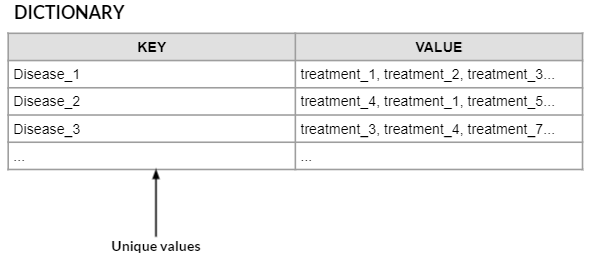

## Creating Dataframe for Disease	and Treatments

In [ ]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [ ]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,cellulitis,G-CSF therapy intravenous antibiotic treatment
...,...,...
101,temporomandibular joint arthropathy,arthroscopic treatment
102,severe secondary peritonitis,Surgical management
103,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
104,Poliomyelitis prevention,live oral poliovirus vaccines


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Model2: Adding POS tag in feature

In [ ]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos] # adding POS tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1] # adding POS tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [ ]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ']

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'BEG']

In [ ]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [ ]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [ ]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [ ]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9084959826402573


## Creating Dataframe for Disease	and Treatments

In [ ]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [ ]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina,roxithromycin
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,foot infection,G-CSF treatment
...,...,...
106,severe secondary peritonitis,Surgical management
107,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
108,chronic renal failure,Epoetin
109,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


### we can see some improvement in accuracy from 90.413 to 90.595

- lets try adding Depency tag and see result

## Model3: Adding POS tag and Dependancy tag in feature

In [ ]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [ ]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [ ]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [ ]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [ ]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [ ]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9096947584655203


## Creating Dataframe for Disease	and Treatments

In [ ]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [ ]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,had myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
107,severe secondary peritonitis,Surgical management
108,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
109,chronic renal failure,Epoetin
110,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


### we can see some improvement in accuracy from 90.595 to 90.693

- lets try increasing max_iterations to 500

## Model 4: max_iterations to 500

In [ ]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [ ]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [ ]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [ ]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [ ]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=500)

In [ ]:
crf.fit(X_train, y_train)

CRF(max_iterations=500)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9106955156007338


## Creating Dataframe for Disease	and Treatments

In [ ]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [ ]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,epilepsy,Methylphenidate
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
103,temporomandibular joint arthropathy,arthroscopic treatment
104,severe secondary peritonitis,Surgical management
105,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
106,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
dise = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## We can see some improvement in accuracy from 90.693 to 91.195
- And we can see there is an increase in the number of record of disease and treatement from 108 to 111.


# Here we can still see the the treatment for the disease name: 'hereditary retinoblastoma' is radiotherapy.